# Autoencoder trained in tag 2 Pt.1
John Ignacio R.M. 2020-06-04

In [1]:
#ada
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada import get_trainvaltest_from_csv, KerasModelGamma

#libs
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1
from keras.optimizers import adam
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score,
precision_recall_curve, average_precision_score)
import seaborn as sns

Welcome to JupyROOT 6.20/04
Using TensorFlow backend.


In [2]:
data_path = "../processed_data"
signal = "Xtohh2000"
seed = 420

In [3]:
sets = get_trainvaltest_from_csv(data_path, signal, .6, .2, .2, seed, region = "SR", tag = 2)

In [4]:
x_train, x_val, x_test = sets["x"].values()
y_train, y_val, y_test = sets["y"].values()
w_train, w_val, w_test = sets["w"].values()
print(x_train.shape, x_val.shape, x_test.shape)

(5241, 14) (1748, 14) (1748, 14)


In [5]:
#dividing the classes
x_train_0 = x_train[y_train == 0]
x_train_1 = x_train[y_train == 1]
w_train_0 = w_train[(y_train == 0).ravel()]
w_train_1 = w_train[(y_train == 1).ravel()]

x_val_0 = x_val[y_val == 0]
x_val_1 = x_val[y_val == 1]
w_val_0 = w_val[(y_val == 0).ravel()]
w_val_1 = w_val[(y_val == 1).ravel()]

print(x_train_1.shape, x_val.shape, x_test.shape)

(5138, 14) (1748, 14) (1748, 14)


In [6]:
class KerasAutoencoder1(KerasModelGamma):

    def __init__(self, n_features):
        input_layer = Input(shape=(n_features, ))
        encoder_1 = Dense(8, activation="relu", activity_regularizer=l1(1e-2))(input_layer)
        encoder_2 = Dense(4, activation="relu")(encoder_1)
        latent = Dense(2, activation="relu")(encoder_2)
        decoder_1 = Dense(4, activation="relu")(latent)
        decoder_2 = Dense(8, activation="relu")(decoder_1)
        output_layer = Dense(n_features, activation="sigmoid")(decoder_2)
        self.model = Model(inputs = input_layer, outputs=output_layer)

        #compile
        self.model.compile(loss='mean_squared_error', optimizer=adam(lr=0.05))

        #title
        self.title = 'optimizer: adam , lr = 0.01, loss = mean squared error'

        #training
        self.history = None

        #name
        self.model_name = "KA1"

Train on 5138 samples, validate on 1702 samples
Epoch 1/50
5138/5138 [==============================] - 2s 320us/step - loss: 0.0356 - val_loss: 0.0011
Epoch 2/50
5138/5138 [==============================] - 0s 77us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/50
5138/5138 [==============================] - 0s 81us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
5138/5138 [==============================] - 0s 63us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/50
5138/5138 [==============================] - 0s 44us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/50
5138/5138 [==============================] - 0s 50us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
5138/5138 [==============================] - 0s 46us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
5138/5138 [==============================] - 0s 51us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
5138/5138 [==============================] - 0s 44us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/50
5138/5138 [=

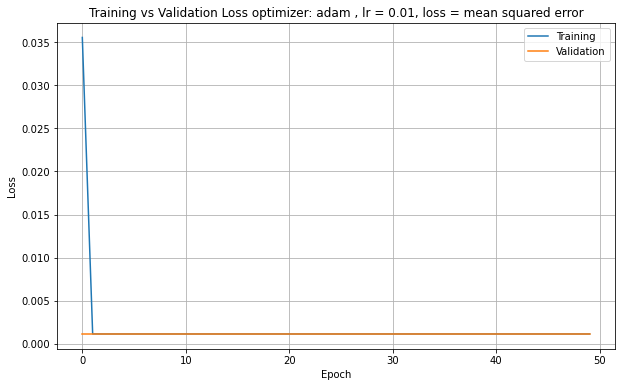

2020-06-05 15:54:48.046688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-05 15:54:48.051007: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2020-06-05 15:54:48.051096: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: valkyrie
2020-06-05 15:54:48.051120: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: valkyrie
2020-06-05 15:54:48.057040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.64.0
2020-06-05 15:54:48.057183: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.64.0
2020-06-05 15:54:48.057209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.64.0
2020-06-05 15:54:48.058029: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU

In [7]:
autoencoder_1 = KerasAutoencoder1(x_train.shape[1])
autoencoder_1.fit(x_train_1, x_train_1, w_train_1, x_val_1, x_val_1, w_val_1, 50)
autoencoder_1.plot_training()

In [8]:
val_scores = autoencoder_1.model.predict(x_val)
val_mse = np.mean(np.power(x_val - val_scores, 2), axis=1)

error_val = pd.DataFrame({'Reconstruction_error': val_mse, 'True_class': y_val.ravel()})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_val.True_class, error_val.Reconstruction_error)

precision_rt = precision_rt[1:]#[threshold_rt <= 1.0]
recall_rt = recall_rt[1:]#[threshold_rt <= 1.0]
#threshold_rt = threshold_rt[threshold_rt <= 1.0]

Threshold intersection:  [0.29762959 0.29805428 6.28883246 6.51670444]


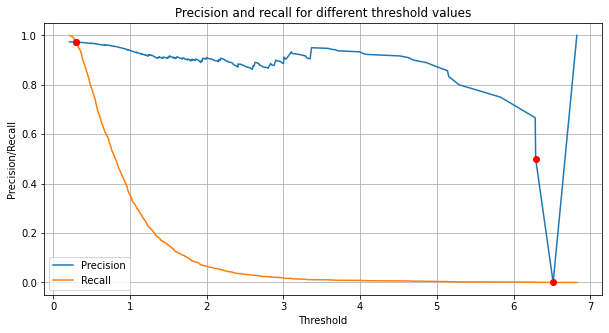

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(threshold_rt, precision_rt, label="Precision")
plt.plot(threshold_rt, recall_rt, label="Recall")
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid()

idx = np.argwhere(np.diff(np.sign(precision_rt - recall_rt))).flatten()
plt.plot(threshold_rt[idx], precision_rt[idx], 'ro')

print("Threshold intersection: ", threshold_rt[idx])
plt.show()

In [11]:
test_scores = autoencoder_1.model.predict(x_test)
test_mse = np.mean(np.power(x_test - test_scores, 2), axis=1)

error_test = pd.DataFrame({'Reconstruction_error': test_mse, 'True_class': y_test.ravel()})
display(error_test)
error_test = error_test.reset_index()
threshold_fixed = 0.3
groups = error_test.groupby('True_class')

,Reconstruction_error,True_class
0,0.897687,1
1,2.362667,1
2,0.876670,1
3,2.886513,1
4,0.984593,1
...,...,...
1743,0.862020,1
1744,1.240921,1
1745,0.594953,1
1746,1.714149,0


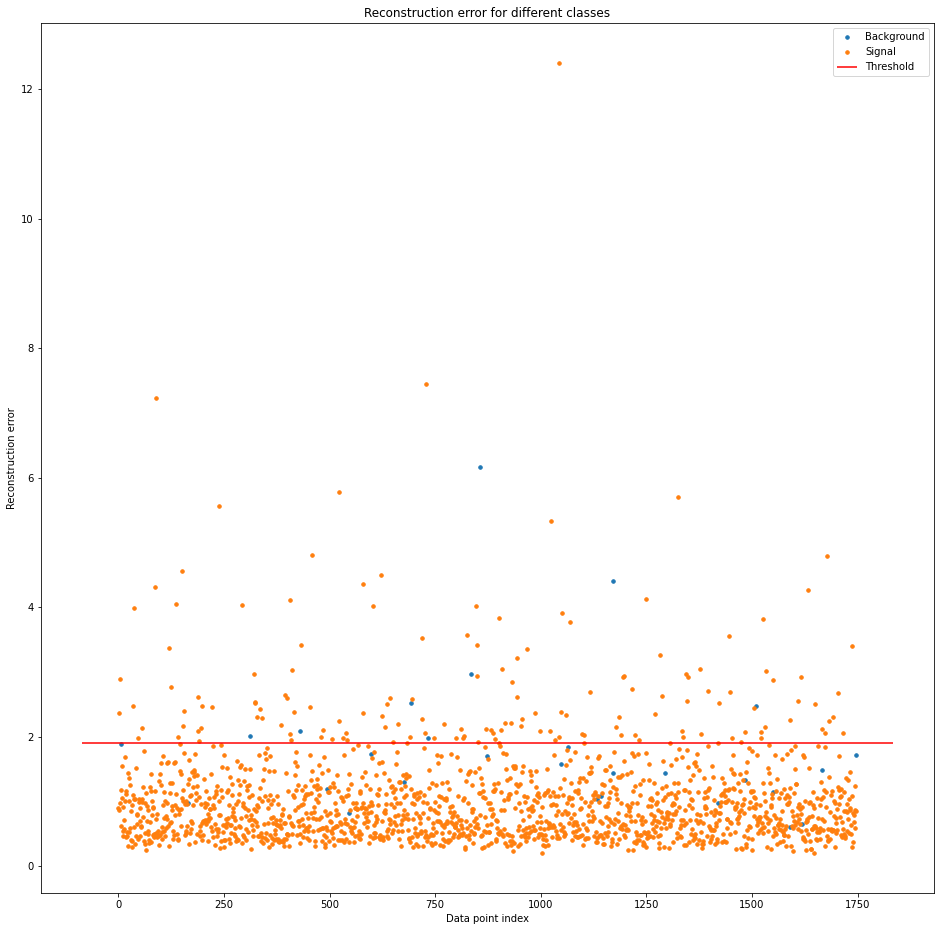

In [12]:
fig, ax = plt.subplots(figsize=(16, 16))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "Background" if name == 0 else "Signal")
ax.hlines(1.9, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

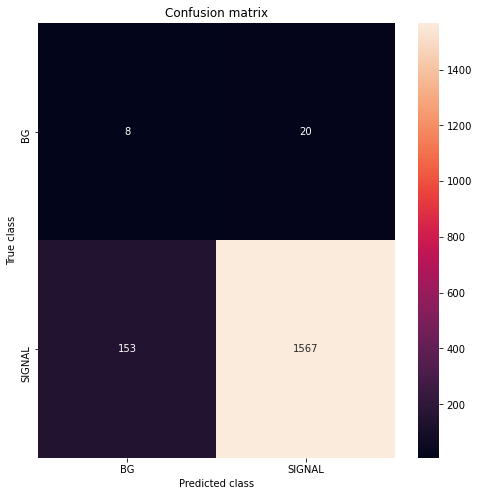

In [13]:
pred_y = [0 if e > 1.9 else 1 for e in error_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_test.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=["BG", "SIGNAL"], yticklabels=["BG", "SIGNAL"], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()